In [50]:
from influxdb import DataFrameClient
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib

host = '192.168.4.33'
port = 8086
user = ''
password = ''
db_name = 'Labview'

query_body = """

SELECT  npt, ngp,t5_average_temperature,engine_pcd ,t1_temperature, turb_air_inlet_filter_dp, gas_fuel_flow_x

FROM Unit1

WHERE time > \'2018-05-24T03:30:00Z\'

"""


LIN_REG = 'Linear Regression'
ALGORYTHM = 'LIN_REG'
# ALGORYTHM = ''
PLOT_TITLE = 'Prediction of Gas Flow. Prediction and Test'


class GasFlow_Predictor():

    def __init__(self, train_p=0.8):
        
        self.regr = LinearRegression(normalize=True)
        self.variance = -1
        self.mse = -1
        self.train_p = train_p

    def get_data_from_influx(self, host, port, user, password, db_name):

        self.client = DataFrameClient(host, port, user, password, db_name)

        self.data = self.client.query(query_body)

    def read_data(self):
        
        self.new_data = dict(self.data)

        for i in self.new_data:
            
            self.my_data = self.new_data[i]
            
    def prepare_data(self):

        self.my_data = self.my_data.reset_index()
        
        print(self.my_data.shape)

        self.my_data = self.my_data.dropna()
        
        print(self.my_data.shape)

        
        print(self.my_data.corr()[['gas_fuel_flow_x']].sort_values('gas_fuel_flow_x'))  

        self.my_data = self.my_data.set_index('index')
        
        #print(self.my_data.head())

        self.x_data = self.my_data.drop('gas_fuel_flow_x', axis = 1)
        
        print(self.x_data.columns)

        self.y_data = pd.DataFrame(self.my_data['gas_fuel_flow_x'], index = self.my_data.index)
        
        print(self.y_data.columns)

        index = int(len(self.x_data) * self.train_p)

        self.x_train = self.x_data[:index]
        
      #  print(x_train.shape)

        self.y_train = self.y_data[:index]

        self.x_test = self.x_data[index:]

        self.y_test = self.y_data[index:]

    def train(self):

        model = self.regr.fit(self.x_train, self.y_train)

        joblib.dump(model, 'lin_reg_model.pkl')

    def predict(self):
        
        self.y_pred = self.regr.predict(self.x_test)

        

    def error(self):
        # print('Coefficients: \n', self.regr.coef_)
        self.mse = mean_squared_error(self.y_test, self.y_pred)
        print("Mean squared error: %.2f" % self.mse)
        # Explained variance score: 1 is perfect prediction
        self.variance = r2_score(self.y_test, self.y_pred)

        print(self.variance)

    def plot(self, title=PLOT_TITLE):

        xx = range(len(self.x_test))

        plt.rcParams['figure.figsize'] = (25, 10)

        plt.plot(xx, self.y_pred, 'r-', label = 'predicted', linewidth=1)

        plt.plot(xx, self.y_test, 'b-', label = 'test', linewidth=1)

        plt.title(title)
        plt.legend()
        plt.xlabel('Variance: {} MSE: {}'.format(self.variance, self.mse))

        plt.show()



In [51]:
kettik = GasFlow_Predictor()

In [52]:
kettik.get_data_from_influx(host, port, user, password, db_name)

In [53]:
kettik.read_data()

In [54]:
kettik.prepare_data()

(20658, 8)
(196, 8)
                          gas_fuel_flow_x
npt                              0.017672
t5_average_temperature           0.154270
engine_pcd                       0.158790
ngp                              0.183235
gas_fuel_flow_x                  1.000000
t1_temperature                        NaN
turb_air_inlet_filter_dp              NaN
Index(['engine_pcd', 'ngp', 'npt', 't1_temperature', 't5_average_temperature',
       'turb_air_inlet_filter_dp'],
      dtype='object')
Index(['gas_fuel_flow_x'], dtype='object')


In [55]:
kettik.train()

In [56]:
kettik.predict()

In [57]:
kettik.error()

Mean squared error: 0.00
-0.05714010928835589


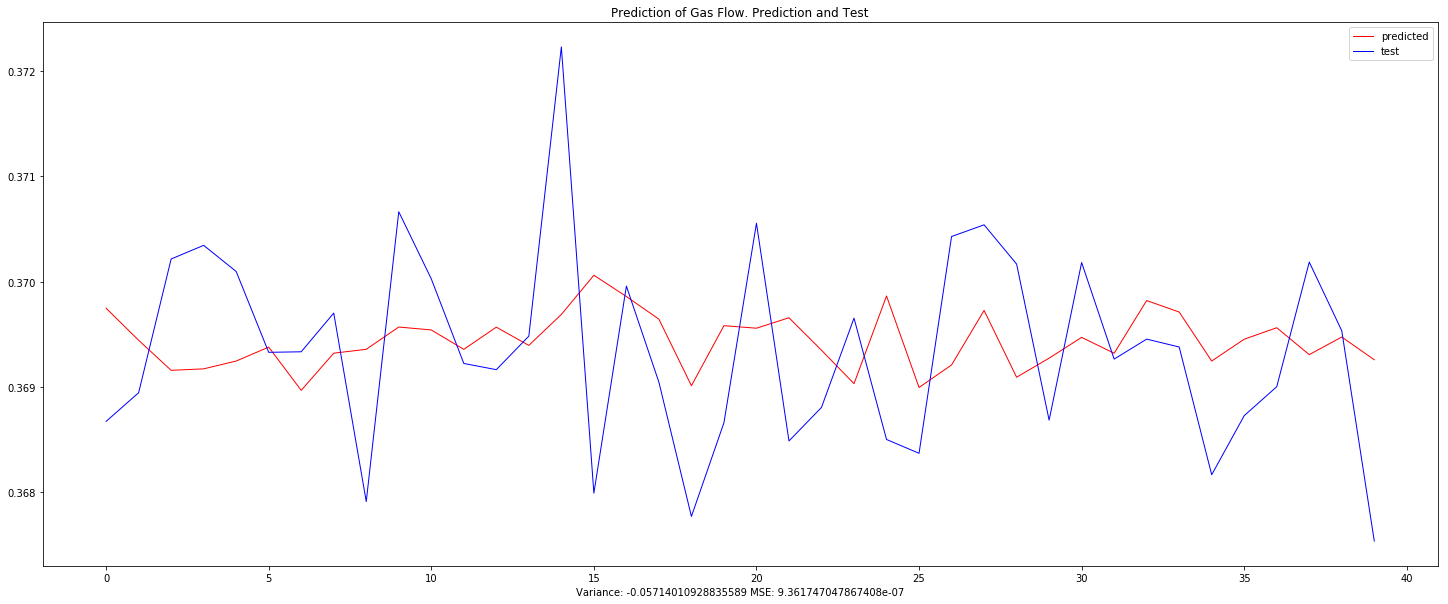

In [58]:
kettik.plot()